In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import sys

from pathlib import Path

In [140]:
FILEPATH = Path('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206')
FILENAMES = ['PROCESSED_SU000001.json',
             'PROCESSED_2_SU000001.json',
             'COMBINED_RESULTS.json']

try:
    with open(Path(FILEPATH, FILENAMES[0]), 'r') as f1:
        data1 = json.load(f1)
    print(sys.getsizeof(data1))

    with open(Path(FILEPATH, FILENAMES[1]), 'r') as f2:
        data2 = json.load(f2)
    print(sys.getsizeof(data2))

    # Combine the data (handle different structures)
    if isinstance(data1, list) and isinstance(data2, list):
        combined_data = data1 + data2  # Concatenate lists
    elif isinstance(data1, dict) and isinstance(data2, dict):
        combined_data = {**data1, **data2}  # Merge dictionaries (Python 3.5+)
    else:
        print("Warning: JSON files have incompatible structures. Attempting simple concatenation.")
        combined_data = [data1, data2]
    print(sys.getsizeof(combined_data))

    with open(Path(FILEPATH, FILENAMES[2]), 'w') as out_file:
        json.dump(combined_data, out_file, indent=4) # indent for readability
    print(f"JSON files combined and saved to {Path(FILEPATH, FILENAMES[2])}")

except FileNotFoundError as e:
    print(f"Error: File not found - {e.filename}")
except json.JSONDecodeError as e:
    print(f"Error: Invalid JSON format - {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

6576
13056
13056
JSON files combined and saved to /Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206/COMBINED_RESULTS.json


In [170]:
FILEPATH = Path(
    '/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Lisa_ChirpArray_Ethanol.csv')

data = pd.read_csv(FILEPATH)
data.head()

,ID,ROI,ROI_label,Timestamp,Image_brightness,Image_contrast,Analysis,Filepath,Amplitude,Amplitude-std,...,Offset-lq,Offset-uq,Offset-median,Offset-max,Error,Error-std,Error-lq,Error-uq,Error-median,Error-max
0,img_000000000_Default_000,ROI_115_1_A,115_1_A,0,0.04,0.0,gaussian,K:/Lisa/GMR/Array/250206/Experiment_1_ethanol/...,1.379,1.286,...,0.014,0.150,0.041,0.274,0.259,0.102,0.162,0.355,0.251,0.443
1,img_000000000_Default_000,ROI_115_1_B,115_1_B,0,0.04,0.0,gaussian,K:/Lisa/GMR/Array/250206/Experiment_1_ethanol/...,1.843,1.651,...,-0.017,0.128,0.070,0.167,0.274,0.063,0.232,0.333,0.273,0.368
2,img_000000000_Default_000,ROI_116_1_A,116_1_A,0,0.04,0.0,gaussian,K:/Lisa/GMR/Array/250206/Experiment_1_ethanol/...,1.658,1.667,...,0.081,0.394,0.332,0.466,0.377,0.142,0.303,0.478,0.463,0.495
3,img_000000000_Default_000,ROI_116_1_B,116_1_B,0,0.04,0.0,gaussian,K:/Lisa/GMR/Array/250206/Experiment_1_ethanol/...,1.387,1.211,...,0.007,0.356,0.245,0.403,0.335,0.162,0.201,0.475,0.425,0.486
4,img_000000000_Default_000,ROI_117_1_A,117_1_A,0,0.04,0.0,gaussian,K:/Lisa/GMR/Array/250206/Experiment_1_ethanol/...,1.276,0.793,...,-0.094,0.233,0.000,0.528,0.295,0.122,0.230,0.420,0.253,0.497


In [220]:
def get_ROI_labels(data):
    ROIs_1 = data[data['ROI_label'].str.contains('_1_')]['ROI_label']
    ROIs_2 = data[data['ROI_label'].str.contains('_2_')]['ROI_label']

    ROIs_1_prefix = ROIs_1.apply(lambda label: label[:-2]).unique()
    ROIs_2_prefix = ROIs_2.apply(lambda label: label[:-2]).unique()
    # print(ROIs_1_prefix)
    # print(ROIs_2_prefix)
    return ROIs_1_prefix, ROIs_2_prefix


In [214]:
def add_columns(df_A, df_B, column_name):
    col1 = df_A[column_name].astype(float)
    col2 = df_B[column_name].astype(float)
    combined_col = col1 + col2
    return combined_col

In [215]:
def average_columns(df_A, df_B, column_name):
    col1 = df_A[column_name].astype(float)
    col2 = df_B[column_name].astype(float)
    combined_col = (col1 + col2) / 2
    return combined_col

In [216]:
def align_dfs(df_A, df_B):
    combined_index = df_A.index.union(df_B.index)
    df_A = df_A.reindex(combined_index)
    df_B = df_B.reindex(combined_index)
    return df_A, df_B

In [224]:
def write_csv_per_ROI(ROI_label_prefixs, savepath):
    filepaths = []
    for l in ROI_label_prefixs:
        temp_A = data[data['ROI_label'] == f'{l}_A'].copy()
        temp_A = temp_A.set_index('Timestamp', drop=False, inplace=False)
        temp_B = data[data['ROI_label'] == f'{l}_B'].copy()
        temp_B = temp_B.set_index('Timestamp', drop=False, inplace=False)
        temp_A, temp_B = align_dfs(temp_A, temp_B)
        
        new_df = pd.DataFrame(index=temp_A.index)

        cols_to_copy = ['ID', 'ROI', 'ROI_label', 'Timestamp',
                        'Filepath', 'Image_brightness', 'Image_contrast',
                        'Analysis']
        for col in cols_to_copy:
            new_df[col] = temp_A[col].copy()

        for col in data.columns:
            if col in cols_to_copy:
                continue
            elif col in ['Position', 'Position-lq', 'Position-uq', 'Position-median', 'Position-max']:
                new_df[col] = add_columns(temp_A, temp_B, col)
            else:
                new_df[col] = average_columns(temp_A, temp_B, col)
        filepath = Path(savepath, f'{l}.csv')
        filepaths.append(filepath)
        new_df.to_csv(filepath, index=False)
    return filepaths

In [225]:
SAVEPATH = Path(
    '/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/1_gratings')

ROIs_1_prefix, ROIs_2_prefix = get_ROI_labels(data)
ROIs_1_filepaths = write_csv_per_ROI(ROIs_1_prefix, SAVEPATH)
ROIs_2_filepaths = write_csv_per_ROI(ROIs_2_prefix, SAVEPATH)

In [226]:
ROIs_1_filepaths

[PosixPath('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/1_gratings/115_1.csv'),
 PosixPath('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/1_gratings/116_1.csv'),
 PosixPath('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/1_gratings/117_1.csv'),
 PosixPath('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/1_gratings/124_1.csv'),
 PosixPath('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/1_gratings/125_1.csv'),
 PosixPath('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/1_gratings/126_1.csv'),
 PosixPath('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/1_gratings/127_1.csv'),
 PosixPath('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/1_gratings/135_1.csv'),
 PosixPath('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/1_gratings/136_1.csv'),
 PosixPath('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Re

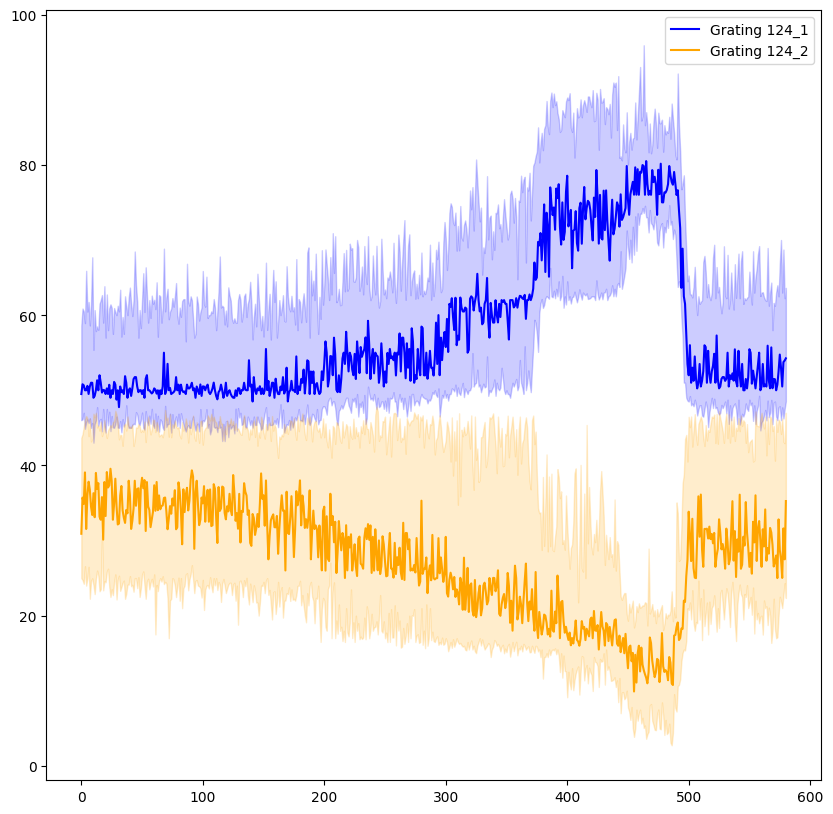

In [294]:
grating = '124' #127, 197, 198, 194, 195, 124
ROOT = Path('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/Results/')
FILE1 = Path('1_gratings', f'{grating}_1.csv')
FILE2 = Path('2_gratings', f'{grating}_2.csv')

PLOT = True
try:
    data1 = pd.read_csv(Path(ROOT, FILE1))
    data2 = pd.read_csv(Path(ROOT, FILE2))
except FileNotFoundError:
    print('No data')
    PLOT = False

if PLOT:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    try:
        ax.plot(data1['Position-median'], color='blue', label=f'Grating {grating}_1')
        ax.fill_between(data1['Timestamp'], data1['Position-lq'], data1['Position-uq'], color='blue', alpha=0.2)
        ax.plot(data2['Position-median'], color='orange', label=f'Grating {grating}_2')
        ax.fill_between(data2['Timestamp'], data2['Position-lq'], data2['Position-uq'], color='orange', alpha=0.2)
    except:
        pass
    ax.legend()
    plt.show()

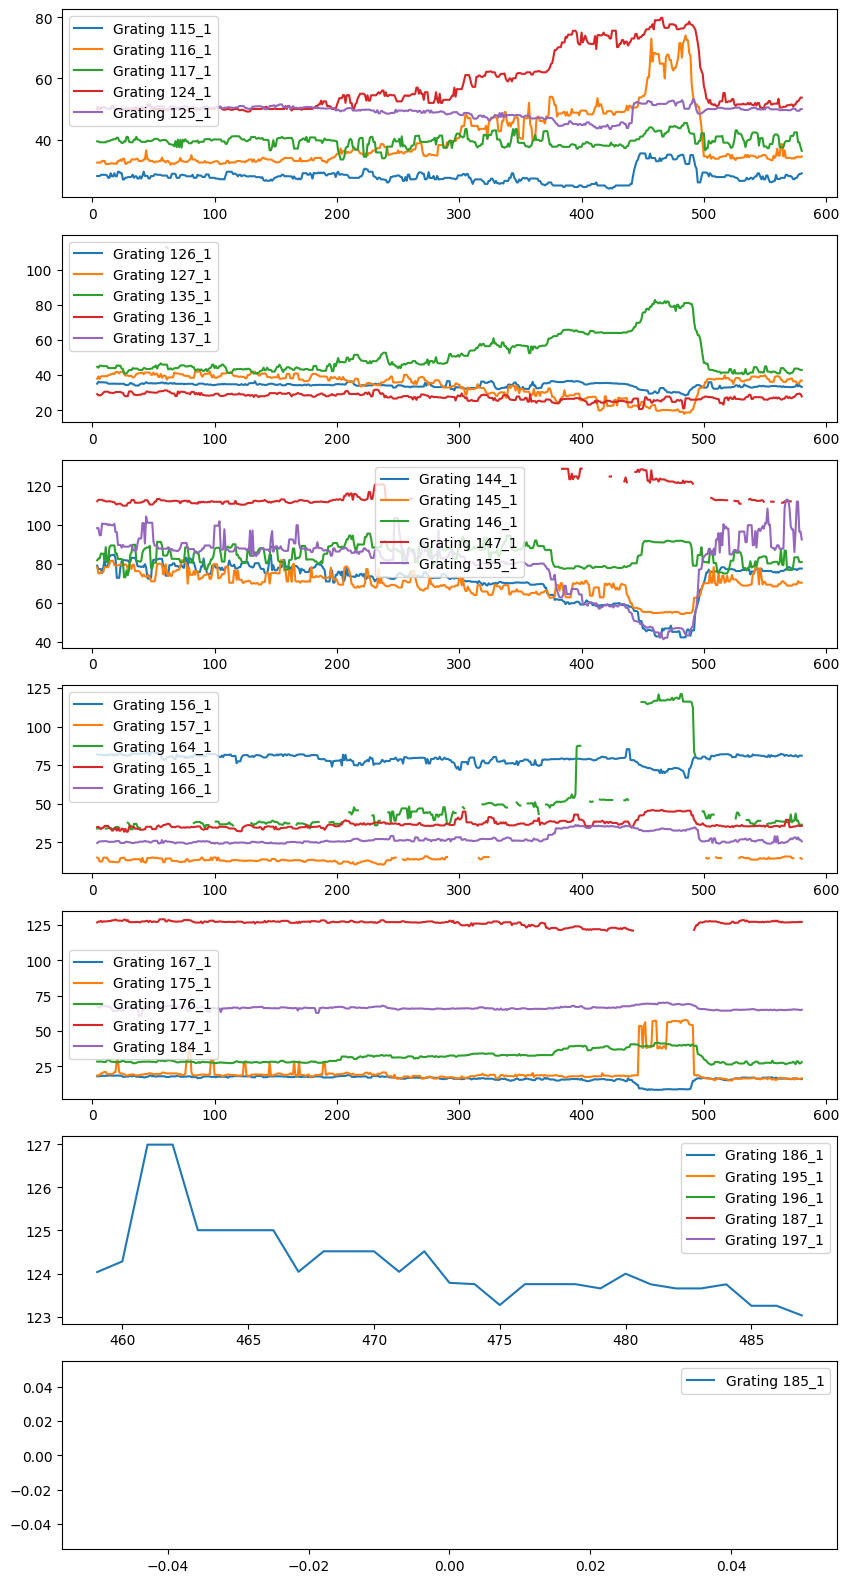

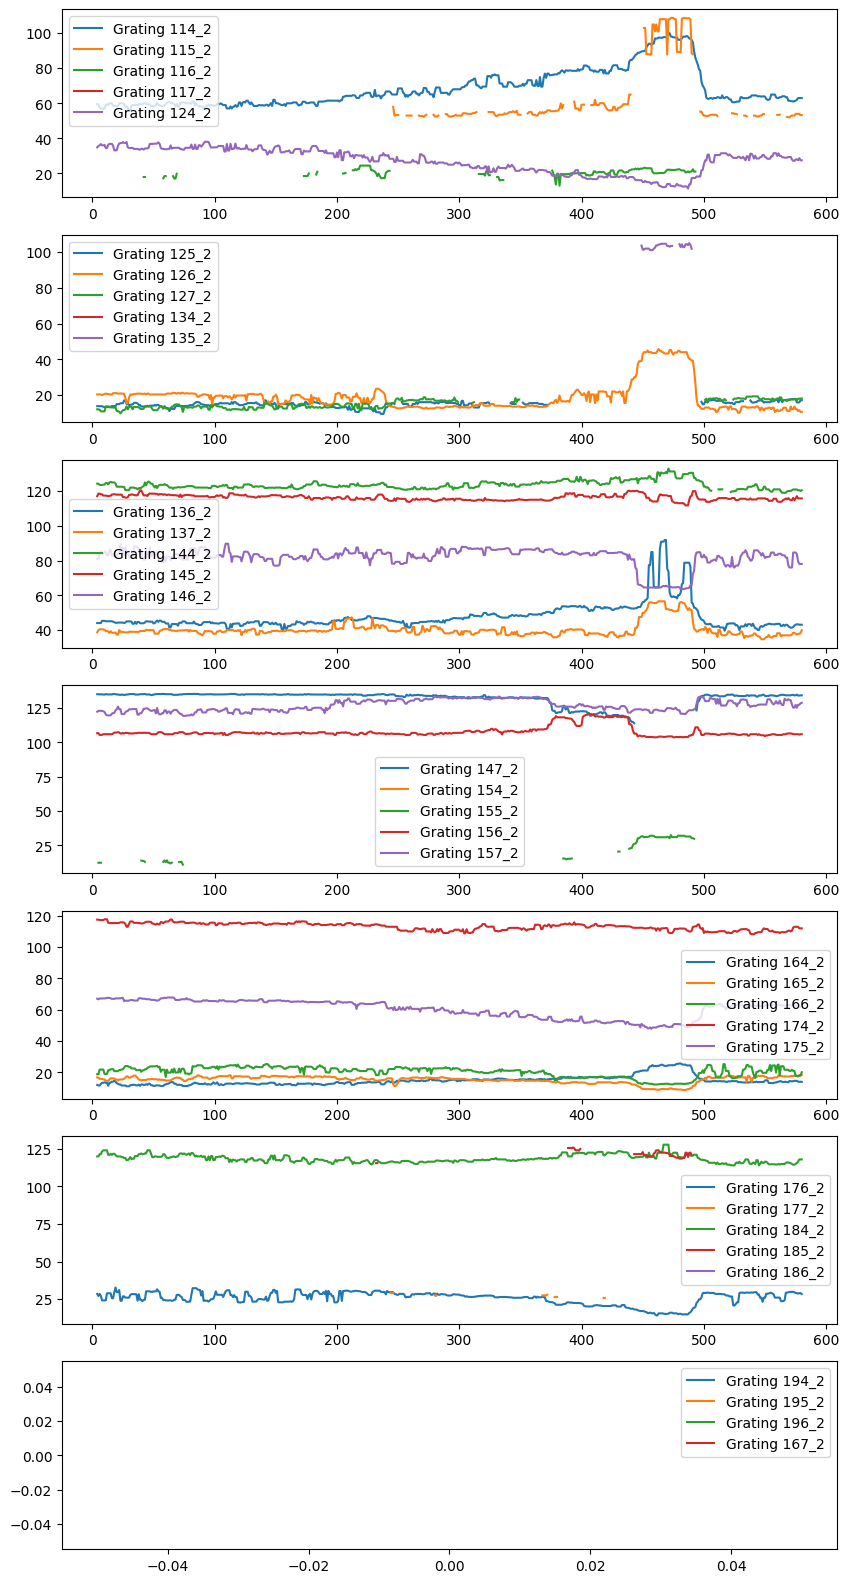

In [333]:
fig, ax = plt.subplots(7, 1, figsize=(10, 20))
ax = ax.ravel()
count = 0
ax_idx = 0
for f in ROIs_1_filepaths:
    PLOT = True
    try:
        data1 = pd.read_csv(f)
    except FileNotFoundError:
        print(f'No data - {f.name}')
        PLOT = False

    if PLOT:
        count += 1
        ax[ax_idx].plot(data1['Position-median'].rolling(window=5).median(),
                label=f'Grating {f.name[:-4]}')
        # ax.fill_between(data1['Timestamp'], data1['Position-lq'],
        #                 data1['Position-uq'], alpha=0.2)
    ax[ax_idx].legend()
    if count % 5 == 0:
        ax_idx += 1
plt.show()

fig, ax = plt.subplots(7, 1, figsize=(10, 20))
ax = ax.ravel()
count = 0
ax_idx = 0
for f in ROIs_2_filepaths:
    PLOT = True
    try:
        data1 = pd.read_csv(f)
    except FileNotFoundError:
        print(f'No data - {f.name}')
        PLOT = False

    if PLOT:
        count += 1
        ax[ax_idx].plot(data1['Position-median'].rolling(window=5).median(),
                        label=f'Grating {f.name[:-4]}')
        # ax.fill_between(data1['Timestamp'], data1['Position-lq'],
        #                 data1['Position-uq'], alpha=0.2)
    ax[ax_idx].legend()
    if count % 5 == 0:
        ax_idx += 1
plt.show()